In [1]:
import os
import math
import numpy as np
import pandas as pd
from datetime import date

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn import  metrics
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, auc, roc_curve 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# 基於 matplotlib 的資料視覺化套件
import seaborn as sns 
plt.style.use( 'ggplot' )   # 設定圖型風格
sns.set( color_codes = True )

In [2]:
Data_Root = '/Users/YenLin/Desktop/ML_100/每日作業/Day_051-Day_053_(Midterm Exam)'

training_data = pd.read_csv( os.path.join( Data_Root, 'train_offline.csv' ) )
testing_data = pd.read_csv( os.path.join( Data_Root, 'test_offline.csv' ) ) 

print( 'Size of Training Data : ' + str( training_data.shape ) )
print( 'Size of Testing Data : ' + str( testing_data.shape ) )

Size of Training Data : (1160742, 7)
Size of Testing Data : (594142, 6)


In [3]:
print( 'Training Data : ' )
training_data.head( 10 )

Training Data : 


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN
5,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN
6,73611,2099,12034.0,100:10,NaN,20160207.0,NaN
7,163606,1569,5054.0,200:30,10.0,20160421.0,NaN
8,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN
9,94107,3381,7610.0,200:20,2.0,20160412.0,NaN


In [4]:
testing_data = testing_data[ ~ testing_data.Coupon_id.isna( ) ]
testing_data.reset_index( drop = True, inplace = True )

print( 'Testing Data : ' )
testing_data.head( 10 )

Testing Data : 


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,1439408,4663,11002.0,150:20,1.0,20160528.0
1,1439408,2632,8591.0,20:1,0.0,20160613.0
2,1439408,2632,8591.0,20:1,0.0,20160516.0
3,2029232,450,1532.0,30:5,0.0,20160530.0
4,2029232,6459,12737.0,20:1,0.0,20160519.0
5,2747744,6901,1097.0,50:10,NaN,20160606.0
6,196342,1579,10698.0,20:1,1.0,20160606.0
7,253750,6901,2366.0,30:5,0.0,20160518.0
8,343660,4663,11002.0,150:20,NaN,20160528.0
9,1113008,3621,2705.0,20:5,0.0,20160524.0


# Create Target Label 

In [5]:
"""
According to the definition, 
1) buy with coupon within (include) 15 days ==> 1
2) buy with coupon but out of 15 days ==> 0
3) buy without coupon ==> -1 (we don't care)
"""
def label( data ) :
    if np.isnan( data[ 'Date_received' ] ) :  # Date_received：優惠券取得時間
        return -1
    if not np.isnan( data[ 'Date' ] ) :         # Date：購買商品時間
        td = pd.to_datetime( data[ 'Date' ], format = '%Y%m%d' ) -  pd.to_datetime( data[ 'Date_received' ], format = '%Y%m%d' )
        if td <= pd.Timedelta( 15, 'D' ) : 
            return 1
    return 0

training_data[ 'label' ] = training_data.apply( label, axis = 1 )
training_data[ 'label' ].value_counts( )

 0    710665
-1    413773
 1     36304
Name: label, dtype: int64

# Replace NaN

### (1) Distance  
- 用戶經常活動地點離商家最近距離 (x * 500 公尺), 0 表示低於 500 公尺, 10 表示大於 5 公里

Counts of NaN in "Distance" column = 69826


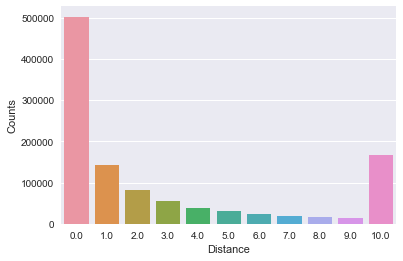

In [6]:
print( 'Counts of NaN in "Distance" column = ' + str( training_data[ 'Distance' ].isnull().sum() ) )


value_counts = training_data[ 'Distance' ].value_counts( dropna = False ).reset_index( )
value_counts.columns = [ 'Distance', 'Counts' ]

x = value_counts[ 'Distance' ]
y = value_counts[ 'Counts' ]
sns.barplot( x, y )
plt.show( ) 


In [7]:
# Calculate the quantile( q0 - q100 ) of 'Distance' column
q_all = [ np.percentile( training_data[ ~training_data[ 'Distance' ].isnull( ) ][ 'Distance' ], q = i ) for i in np.arange( 0, 101 ) ] 
Qth_Percentile = pd.DataFrame( { 'Qth': list( range( 101 ) ), 'Value': q_all } )

In [8]:
# 中位數( median Q50 )
q_50 = Qth_Percentile.iloc[ 50, 1 ]

print( 'Median(中位數) of "Distance" column = ' + str( q_50 ) )

Median(中位數) of "Distance" column = 1.0


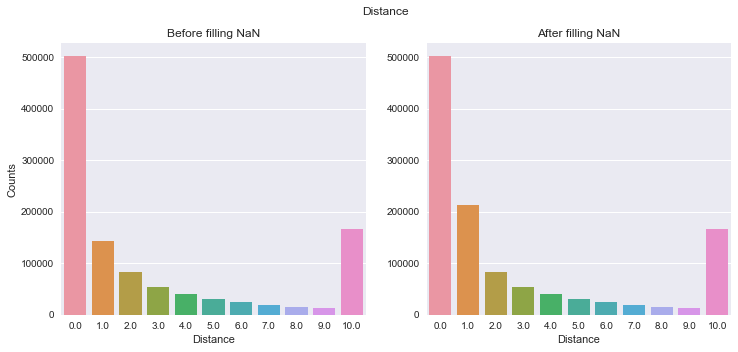

In [9]:
# 填補訓練集距離欄位中的缺漏值
training_data.loc[ training_data[ 'Distance' ].isnull(), 'Distance' ] = q_50


# 比較填補缺漏值前後的資料分布
fillna_value_counts = training_data[ 'Distance' ].value_counts( dropna = False ).reset_index( )
fillna_value_counts.columns = [ 'Distance', 'Counts' ]


fig, axs = plt.subplots( 1, 2, figsize = ( 12, 5 ) )
plt.suptitle( 'Distance' + '\n' )

plt.subplot( 1, 2, 1 )
sns.barplot( x, y )
plt.title( 'Before filling NaN' )
plt.ylabel( 'Counts' ) 

plt.subplot( 1, 2, 2 )
fillna_x = fillna_value_counts[ 'Distance' ]
fillna_y = fillna_value_counts[ 'Counts' ]

sns.barplot( fillna_x, fillna_y )
plt.title( 'After filling NaN' )
plt.ylabel( '' ) 

plt.show( ) 

In [10]:
# 填補測試集距離欄位中的缺漏值
testing_data.loc[ testing_data[ 'Distance' ].isnull(), 'Distance' ] = q_50

# Generate Features

### (1) Date_received( 優惠券取得時間 ) 

###### 'Date_received' convert into Weekday.

In [11]:
def getWeekday( row ) :
    if ( np.isnan( row ) ) or ( row == -1 ) :
        return row
    else:
        return pd.to_datetime( row, format = '%Y%m%d' ).dayofweek + 1  
        # The day of the week with Monday = 0, Sunday = 6.
        # Add one to make it from 0~6 -> 1~7
        

training_data[ 'weekday' ] = training_data[ 'Date_received' ].apply( getWeekday )
testing_data[ 'weekday' ] = testing_data[ 'Date_received' ].apply( getWeekday )

In [12]:
print( 'Counts of Weekday in Training Data : ' '\n' )

Training_weekday_counts = training_data[ 'weekday' ].value_counts( dropna = False ).reset_index( )
Training_weekday_counts.columns = [ 'Weekday', 'Counts' ]
Training_weekday_counts

Counts of Weekday in Training Data : 



,Weekday,Counts
0,NaN,413773
1,7.0,151239
2,5.0,125726
3,1.0,119318
4,6.0,108135
5,4.0,91726
6,3.0,76305
7,2.0,74520


In [13]:
print( 'Counts of Weekday in Testing Data : ' '\n' )

Testing_weekday_counts = testing_data[ 'weekday' ].value_counts( dropna = False ).reset_index( )
Testing_weekday_counts.columns = [ 'Weekday', 'Counts' ]
Testing_weekday_counts

Counts of Weekday in Testing Data : 



,Weekday,Counts
0,6,52076
1,3,46449
2,1,42751
3,5,42345
4,7,41375
5,4,41045
6,2,40272


#### One-Hot Encoder for 'Weekday'

In [14]:
weekday_cols = [ 'weekday_' + str( i ) for i in range( 1, 8 ) ]
print( weekday_cols )

['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [15]:
train_weekday_encoder = pd.get_dummies( training_data[ 'weekday' ] )
train_weekday_encoder.columns = weekday_cols
training_data[ weekday_cols ] = train_weekday_encoder

training_data.head( )

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,NaN,0,0,0,0,0,0,0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,0,1,0,0,0,0
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,0,0,0,0,1,0
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,0,0,0,1,0,0
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,0,0,0,1,0,0


In [16]:
test_weekday_encoder = pd.get_dummies( testing_data[ 'weekday' ] )
test_weekday_encoder.columns = weekday_cols
testing_data[ weekday_cols ] = test_weekday_encoder 

testing_data.head( )

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,1439408,4663,11002.0,150:20,1.0,20160528.0,6,0,0,0,0,0,1,0
1,1439408,2632,8591.0,20:1,0.0,20160613.0,1,1,0,0,0,0,0,0
2,1439408,2632,8591.0,20:1,0.0,20160516.0,1,1,0,0,0,0,0,0
3,2029232,450,1532.0,30:5,0.0,20160530.0,1,1,0,0,0,0,0,0
4,2029232,6459,12737.0,20:1,0.0,20160519.0,4,0,0,0,1,0,0,0


##### Weekday Type

In [17]:
# weekday_type：weekend = 1 ; weekday = 0 ; NaN = -1

# apply to training data
training_data[ 'weekday_type' ] = training_data[ 'weekday' ].apply( lambda x :  -1 if np.isnan(x) else( 1 if x in [6,7] else 0 ) ) 

# apply to testing data
testing_data[ 'weekday_type' ] = testing_data[ 'weekday' ].apply( lambda x : -1 if np.isnan(x) else( 1 if x in [6,7] else 0 ) ) 

##### Week Cycle

In [18]:
training_data[ 'week_cycle' ] = training_data[ 'weekday' ]/14 
training_data[ 'week_cycle' ] = training_data[ 'week_cycle' ].map( lambda x : math.sin( x*math.pi ) )

testing_data[ 'week_cycle' ] = testing_data[ 'weekday' ]/14 
testing_data[ 'week_cycle' ] = testing_data[ 'week_cycle' ].map( lambda x : math.sin( x*math.pi ) )

In [19]:
training_data.head( )

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,weekday_type,week_cycle
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,NaN,0,0,0,0,0,0,0,-1,NaN
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,0,1,0,0,0,0,0,0.623490
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,0,0,0,0,1,0,1,0.974928
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,0,0,0,1,0,0,0,0.900969
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,0,0,0,1,0,0,0,0.900969


In [20]:
testing_data.head( )

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,weekday_type,week_cycle
0,1439408,4663,11002.0,150:20,1.0,20160528.0,6,0,0,0,0,0,1,0,1,0.974928
1,1439408,2632,8591.0,20:1,0.0,20160613.0,1,1,0,0,0,0,0,0,0,0.222521
2,1439408,2632,8591.0,20:1,0.0,20160516.0,1,1,0,0,0,0,0,0,0,0.222521
3,2029232,450,1532.0,30:5,0.0,20160530.0,1,1,0,0,0,0,0,0,0,0.222521
4,2029232,6459,12737.0,20:1,0.0,20160519.0,4,0,0,0,1,0,0,0,0,0.781831


### (2) Discount_rate
- 優惠券折價：$[ 0, 1 ]$ 代表折扣率； x : y 代表滿 x 元減 y 元 

In [21]:
# Generate features - coupon discount

def convertRate( row ) :
    """Convert discount to rate"""
    if pd.isnull( row ) :
        return 1.0
    elif ':' in row :
        rows = row.split( ':' )
        return 1.0 - float( rows[1] ) / float( rows[0] )
    else:
        return float( row )

    
def getDiscountType( row ) :
    if pd.isnull( row ) :
        return -1     # -1 : 無優惠卷折價
    elif ':' in row :
        return 1       # 1 : 消費滿額折扣
    else :
        return 0      # 0 : 消費直接打折(％)



def getDiscountMan( row ) :
    # 達可折扣金額的消費額度
    if ':' in row :
        rows = row.split( ':' )
        return int( rows[0] )
    else:
        return 0

def getDiscountJian( row ) :
    # 消費滿額所折扣的金額
    if ':' in row :
        rows = row.split( ':' )
        return int( rows[1] )
    else:
        return 0
    
    
def GenerateDiscountFeatures( data ) :
    # Convert 'Discunt_rate'
    data[ 'discount_rate' ] = data[ 'Discount_rate' ].apply( convertRate )
    data[ 'discount_man' ] = data[ 'Discount_rate' ].astype( 'str' ).apply( getDiscountMan )
    data[ 'discount_jian' ] = data[ 'Discount_rate' ].astype( 'str' ).apply( getDiscountJian )
    data[ 'discount_type' ] = data[ 'Discount_rate' ].apply( getDiscountType )
    
    return data

In [22]:
training_data = GenerateDiscountFeatures( training_data )
testing_data = GenerateDiscountFeatures( testing_data )

In [23]:
print( 'Size of Training Data = ' + str( training_data.shape ) )
print( 'Features : ' + str( training_data.columns )  )

training_data.head( )

Size of Training Data = (1160742, 22)
Features : Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'label', 'weekday', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'weekday_type', 'week_cycle', 'discount_rate', 'discount_man',
       'discount_jian', 'discount_type'],
      dtype='object')


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,weekday,weekday_1,...,weekday_4,weekday_5,weekday_6,weekday_7,weekday_type,week_cycle,discount_rate,discount_man,discount_jian,discount_type
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,-1,NaN,0,...,0,0,0,0,-1,NaN,1.00,0,0,-1
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0,3.0,0,...,0,0,0,0,0,0.623490,0.95,20,1,1
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0,6.0,0,...,0,0,1,0,1,0.974928,0.95,20,1,1
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0,5.0,0,...,0,1,0,0,0,0.900969,0.90,200,20,1
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0,5.0,0,...,0,1,0,0,0,0.900969,0.90,200,20,1


In [24]:
print( 'Size of Testing Data = ' + str( testing_data.shape ) )
print( 'Features : ' + str( testing_data.columns )  )

testing_data.head( )

Size of Testing Data = (306313, 20)
Features : Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'weekday', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'weekday_type',
       'week_cycle', 'discount_rate', 'discount_man', 'discount_jian',
       'discount_type'],
      dtype='object')


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,weekday_type,week_cycle,discount_rate,discount_man,discount_jian,discount_type
0,1439408,4663,11002.0,150:20,1.0,20160528.0,6,0,0,0,0,0,1,0,1,0.974928,0.866667,150,20,1
1,1439408,2632,8591.0,20:1,0.0,20160613.0,1,1,0,0,0,0,0,0,0,0.222521,0.950000,20,1,1
2,1439408,2632,8591.0,20:1,0.0,20160516.0,1,1,0,0,0,0,0,0,0,0.222521,0.950000,20,1,1
3,2029232,450,1532.0,30:5,0.0,20160530.0,1,1,0,0,0,0,0,0,0,0.222521,0.833333,30,5,1
4,2029232,6459,12737.0,20:1,0.0,20160519.0,4,0,0,0,1,0,0,0,0,0.781831,0.950000,20,1,1


# Split into Train and Validition Data

In [25]:
## Naive model
def split_train_valid( row, date_cut = '20160416' ) :
    is_train = True if pd.to_datetime( row, format = '%Y%m%d' ) < pd.to_datetime( date_cut, format = '%Y%m%d' ) else False
    return is_train
    
Receive_Coupon_Data = training_data[ training_data[ 'label' ] != -1 ].copy( )  # 取出有優惠卷的用戶資料

Receive_Coupon_Data[ 'is_train' ] = Receive_Coupon_Data[ 'Date_received' ].apply( split_train_valid )
train = Receive_Coupon_Data[ Receive_Coupon_Data[ 'is_train' ] ]     # 優惠卷取得時間 < 2016/04/16 的資料
valid = Receive_Coupon_Data[ ~Receive_Coupon_Data[ 'is_train' ] ]   # 優惠卷取得時間 >= 2016/04/16 的資料
train.reset_index( drop = True, inplace = True )
valid.reset_index( drop = True, inplace = True )

print( "Train size: {}, #positive: {}".format( len( train ), train[ 'label' ].sum( ) ) )
print( "Valid size: {}, #positive: {}".format( len( valid ), valid[ 'label' ].sum( ) ) )

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


# Feature Selection

In [26]:
original_features = ['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'week_cycle' ] + weekday_cols


print( 'There are '  + str( len( original_features ) ) + ' original features. ' '\n' )
print( original_features )

There are 15 original features. 

['discount_rate', 'discount_type', 'discount_man', 'discount_jian', 'Distance', 'weekday', 'weekday_type', 'week_cycle', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7']


In [27]:
train_data = train[ original_features ]
train_data.head( )

,discount_rate,discount_type,discount_man,discount_jian,Distance,weekday,weekday_type,week_cycle,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
0,0.95,1,20,1,0.0,3.0,0,0.623490,0,0,1,0,0,0,0
1,0.95,1,20,1,0.0,6.0,1,0.974928,0,0,0,0,0,1,0
2,0.90,1,200,20,1.0,5.0,0,0.900969,0,0,0,0,1,0,0
3,0.50,1,10,5,2.0,5.0,0,0.900969,0,0,0,0,1,0,0
4,0.90,1,100,10,1.0,7.0,1,1.000000,0,0,0,0,0,0,1


In [28]:
Selected_Features = [ 'Distance', 'discount_man', 'discount_jian', 'discount_rate', 'discount_type', 'week_cycle', 'weekday' ]

print( 'Selected_Features : ' )
print( Selected_Features )

Selected_Features : 
['Distance', 'discount_man', 'discount_jian', 'discount_rate', 'discount_type', 'week_cycle', 'weekday']


##### Train and Validation Data for Predictive Model

In [29]:
# Train data and labels
x_train = train[ Selected_Features ]
y_train = train[ 'label' ]

# Validation data and labels
x_valid = valid[ Selected_Features ]
y_valid = valid[ 'label' ]

##### Test Data

In [30]:
# Test data
x_test = testing_data[ Selected_Features ]

# Build the Model

In [31]:
predictors = Selected_Features
print( predictors )

def check_model( data, predictors ) :
    
    classifier = lambda: SGDClassifier(
        loss = 'log', 
        penalty = 'elasticnet', 
        fit_intercept = True, 
        max_iter = 100, 
        shuffle = True, 
        n_jobs = 1,
        class_weight = None )

    model = Pipeline( steps = [
        ( 'ss', StandardScaler( ) ),
        ( 'en', classifier( ) )
    ] )

    parameters = {
        'en__alpha': [ 0.001, 0.01, 0.1],
        'en__l1_ratio': [ 0.001, 0.01, 0.1]
    }

    folder = StratifiedKFold( n_splits = 3, shuffle = True )
    
    grid_search = GridSearchCV(
        model, 
        parameters, 
        cv = folder, 
        n_jobs = -1, 
        verbose = 1 )
    grid_search = grid_search.fit( data[ predictors ], data[ 'label' ] )
    
    return grid_search

['Distance', 'discount_man', 'discount_jian', 'discount_rate', 'discount_type', 'week_cycle', 'weekday']


In [32]:
model = check_model( train, predictors )

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.8min finished
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


In [33]:
y_valid_pred = model.predict_proba( valid[ predictors ] )
valid1 = valid.copy( )
valid1[ 'pred_prob' ] = y_valid_pred[ :, 1 ]

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [34]:
auc_score = roc_auc_score( y_true = valid.label, y_score = y_valid_pred[:,1] )
acc = accuracy_score(y_true = valid.label, y_pred = y_valid_pred.argmax( axis = 1 ) )

print( "Validation AUC: {:.5f}, Accuracy: {:.5f}".format( auc_score, acc ) )

Validation AUC: 0.76444, Accuracy: 0.95163


In [35]:
targetset = testing_data.copy()
print( targetset.shape )
targetset = targetset[ ~ targetset.Coupon_id.isna( ) ]
targetset.reset_index(drop = True, inplace = True )
testset = targetset[predictors].copy()

y_test_pred = model.predict_proba(testset[predictors])
test1 = testset.copy()
test1['pred_prob'] = y_test_pred[:, 1]
print(test1.shape)

(306313, 20)
(306313, 8)


/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:381: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [36]:
output = pd.concat( ( targetset[ [ 'User_id', 'Coupon_id', 'Date_received' ] ], test1[ 'pred_prob' ] ), axis = 1 )
print( output.shape )

output.loc[ :, 'User_id' ] = output[ 'User_id' ].apply( lambda x : str( int(x) ) )
output.loc[ :, 'Coupon_id' ] = output[ "Coupon_id"].apply( lambda x : str( int(x) ) )
output.loc[ :, 'Date_received' ] = output[ "Date_received"].apply( lambda x : str( int(x) ) )
output[ 'uid' ] = output[ [ 'User_id', 'Coupon_id', 'Date_received' ] ].apply( lambda x :  '_'.join( x.values ), axis = 1 )
output.reset_index( drop = True, inplace = True )

(306313, 4)


In [37]:
### NOTE: YOUR SUBMITION FILE SHOULD HAVE COLUMN NAME: uid, label
out = output.groupby( 'uid', as_index = False ).mean( )
out = out[ [ 'uid', 'pred_prob' ] ]
out.columns = [ 'uid', 'label' ]

out.head( )

,uid,label
0,1000020_2705_20160519,0.155613
1,1000020_8192_20160513,0.150363
2,1000065_1455_20160527,0.108907
3,1000085_8067_20160513,0.121714
4,1000086_2418_20160613,0.125143


# Submission File for Kaggle

In [38]:
out.to_csv( 'Midterm_Submission_8.csv', index = False ) # submission format